# Chapter 1: Accelerometer data smoothing and filtering  

Most sensor data is affected to some extent by noise. In this tutorial, we show you a noisy accelerometer signal and describe several techniques to remove noise from the signal. These techniques are also described in the corresponding chapter.

In [1]:
import glob
import matplotlib
from matplotlib import cm
import sys
import math
import numpy as np
import pandas as pd
import pylab as pl
from biosppy.signals import ecg
from scipy import signal

import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt, firwin

matplotlib.style.use('ggplot')
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

## Noisy accelerometer signals

In this example, we will look at removing noise from an accelerometer signal captured from a phone in the pocket while an individual is walking. There are many sources of noise in accelerometer signals from a smartphone or smartwatch/fitness band. The main noise sources are because the phone is moving around in your pocket or bag while walking, or a wristband moving a little on your wrist as you move it. 

Even if you are stationary, there are micro-tremors of the hand or body that are picked up by the accelerometer. In some cases, there are also external noise sources. For example, if you are on an elevator, some of the vibrations of the elevator are transmitted to your phone and captured by it. Similarly, when a phone is placed on a desk, the vibrations of the HVAC system are often transmitted to the phone. This noise needs to be removed before you can further process the signal.

In [2]:
def pull_data(dir_name, file_name):
    f = open(dir_name + '/' + file_name + '.csv')
    xs = []
    ys = []
    zs = []
    rs = []
    timestamps = []
    for line in f:
        value = line.split(',')
        if len(value) > 3:
            timestamps.append(float(value[-4]))
            x = float(value[-3])
            y = float(value[-2])
            z = float(value[-1])
            r = math.sqrt(x ** 2 + y ** 2 + z ** 2)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            rs.append(r)
    return np.array(xs), np.array(ys), np.array(zs), np.array(rs), np.array(timestamps)


## Time-domain noise removal: Moving Average Filter

Many sources of noise tend to be random in nature. Informally, this means that the noise has roughly equal amounts of positive and negative changes, and there is no pattern in the noise over time. 

In this case, noise can be reduced by weighted averaging the values. For example, take the case where you are writing an algorithm to determine the rotation of the screen of the mobile phone. Since you have noise due to small hand movements (if you are holding the phone), you may perform a weighted average of every 10 samples readings and use the smoothed signal in the application to determine whether the screen has rotated. In this way, the noise in the acceleration signal is reduced. 

We are going to try to smooth the data with a moving average filter, which is a simple filter where the weights are all one. The function "convolve" takes a window corresponding to the moving average weights and essentially multiplies it with the data. The result is the smoothed signal. There are two key parameters to think about when designing an averaging filter. The first is the window size and the second is the set of weights.  

<IPython.core.display.Javascript object>


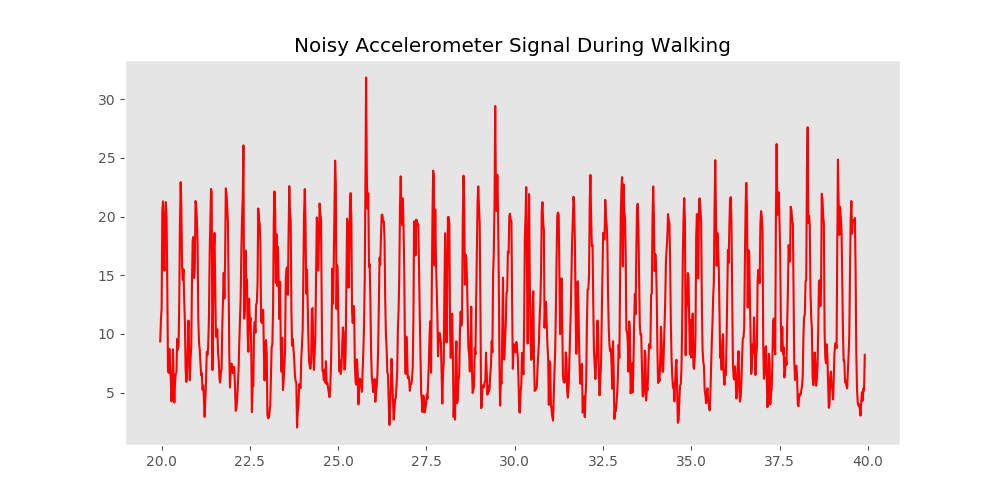

In [3]:
# read accelerometer data file
accel_file = 'data/inPocket-Steps'
x_data, y_data, z_data, signal, timestamps = pull_data(accel_file, 'accelerometer')

c = timestamps[0]
timestamps = (timestamps - c)/1000000000

signal = signal[1000:2000]
timestamps = timestamps[1000:2000]

plt.figure(figsize=(10,5))
pl.plot(timestamps, signal, 'r-',label='unfiltered')
plt.title("Noisy Accelerometer Signal During Walking")
pl.grid()
pl.show()

#### Parameters: Window size and weights
There are two key parameters to think about when designing an averaging filter. The first is the window size and the second is the set of weights.  
* <b>Window size</b>: The window size determines how much smoothing is performed on the signal. In the example below, we are going to replace each sample by the average of a window of ten samples around it. We could have averaged more nearby points to smooth even more aggressively. As you increase the smoothing window, the signal will look cleaner and more visually pleasing, but beware of using too large a window since you will smooth out the important characteristics of the signal (for example, steps if you want to do step detection). Try increasing window size and see the effect.
* <b>Weights</b>: The moving average smoothing in the example below gives equal weight to the set of values that are averaged. np.ones((window_size,))/window_size gives a weight of 1/10 to each of the samples in the example below. But  you can construct other filters by varying the weights. For example, the idea in exponential smoothing is to assign exponentially decreasing weights as the observation get older. In other words, recent observations are given relatively more weight than the older observations.

<IPython.core.display.Javascript object>


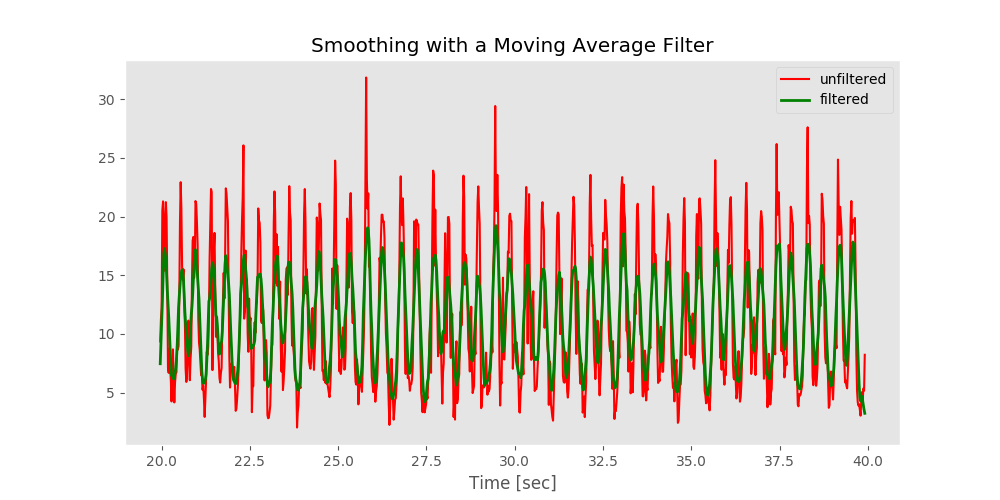

In [4]:
# Moving average with window size
window_size = 10
filtered_signal = np.convolve(signal, np.ones((window_size,))/window_size, mode='same')

plt.figure(figsize=(10,5))
plt.title("Smoothing with a Moving Average Filter")
plt.plot(timestamps, signal, 'r-', label='unfiltered')
plt.plot(timestamps, filtered_signal, 'g-', linewidth=2, label='filtered')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.show()

## Frequency-domain filtering: Butterworth Filter

Let us now turn to noise in the frequency domain. Frequency-domain noise can be removed by a combination of frequency filters. A low-pass filter can remove high frequency components while letting through low frequency components. A high pass filter does the reverse and lets high frequency components through while removing low frequency components. A notch filter removes a specific frequency from the signal. 

We are now going to use a filter called a 'butterworth filter' to remove noise. A Butterworth filter is a popular frequency domain 'lowpass' filter that can remove high frequency noise while only letting the low frequencies through. Since the walking signal is low frequency (only a few steps minute), this is a good approach.

In [5]:
# Filter requirements.
order = 5
fs = 50.0  # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Filter the data, and plot both the original and filtered signals.
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='low', analog=False)
filtered_signal = filtfilt(b, a, signal)

<IPython.core.display.Javascript object>


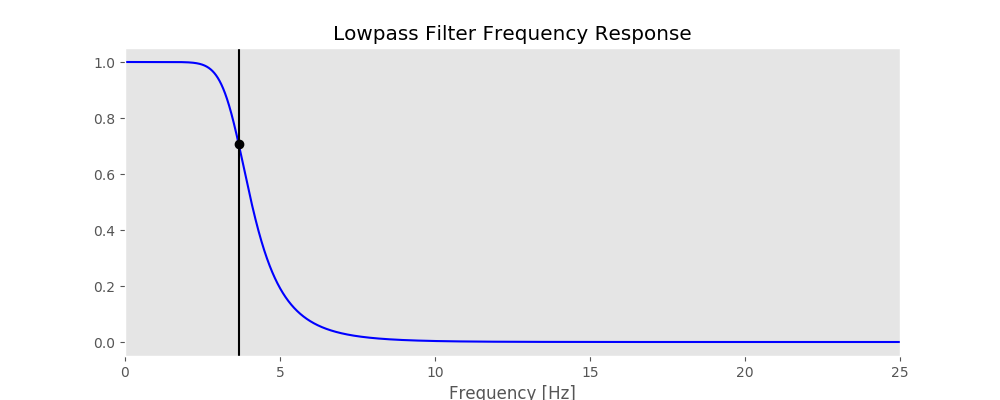

<IPython.core.display.Javascript object>


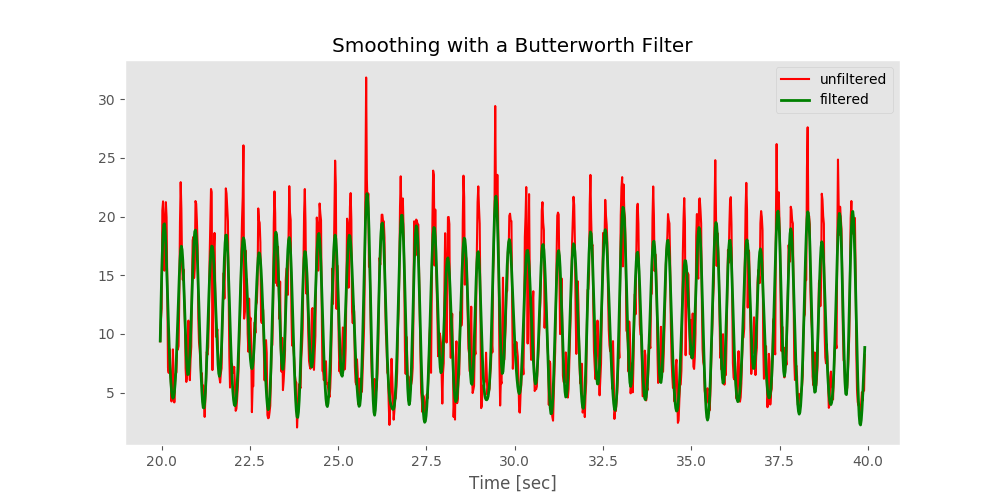

In [6]:
# Frequency response graph
w, h = freqz(b, a, worN=8000)
plt.figure(figsize=(10,4))

plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5 * np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5 * fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Smoothing with a Butterworth Filter")
plt.plot(timestamps, signal, 'r-', label='unfiltered')
plt.plot(timestamps, filtered_signal, 'g-', linewidth=2, label='filtered')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.show()